In [ ]:
'''
In oviraptor_v4, we establish upper and lower bounds for dynamical mass (logmu).  This code determines what those bounds
should be by testing the robustness of certain values of mu.  In order to do this, we manually set boundaries for mu and 
then observe the behavior of the p-values for the KS and AD tests.  If the p-values drastically change when certain values
of mu are reached, we are penetrating into the core distribution of mu, so those certain values of mu should be our 
thresholds.
'''

In [1]:
import numpy as np
import csv
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 10000
import LMC
import archinfo
import imp
import astropy.stats
import scipy
import scipy.signal as sig
import scipy.optimize as op
import dcor
import random
import collections

from scipy import stats
from timeit import default_timer

from sklearn.cluster   import KMeans
from sklearn.cluster   import SpectralClustering
from sklearn.neighbors import DistanceMetric
from sklearn.linear_model import LinearRegression

from KDEpy import FFTKDE

'''
Define a few constants
'''

pi = np.pi
MJUPITER = 1.898e27     #all in SI units
MEARTH = 5.972e24
MSUN = 1.989e30
RJUPITER = 69.911e6
RSUN = 696.34e6
MSATURN = 5.6834e26
BIGG = 6.67e-11
MURANUS = 8.681e25

AU = 1.496e11

REARTH = 6371e3
RNEPTUNE = 24622e3

robinseggblue = '#bfe2ff'    #define a few colors
royalpurple = '#9e00a3'
lavender = '#cc98d9'

NBOOT = 64

In [2]:
class System:
    def __init__(self, sysid=None):
        
        self.sysid = sysid

In [3]:
my_file = 'C:/Users/djhoo/Documents/maiasaurus-master/catalogues/exoarchive_dr25_cks_combined.csv'
raw_data = []
with open(my_file) as infile:
    reader = csv.reader(infile)
    
    for row in reader:
        raw_data.append(row)
        
KEYS = raw_data[0]
VALUES = raw_data[1:]

def get_key(keyname, keys = KEYS, values = VALUES):
    '''
    keyname must be a string
    '''
    i = keys.index(keyname)
    arr = []
    for row in values:
        arr.append(row[i])
    return np.array(arr)

In [4]:
# CONVERT STRINGS TO FLOATS
def is_number(s):
    '''
    checks if input string s is a number
    '''
    if type(s) != list:
        try:
            float(s)
            return True
        except ValueError:
            return False
    else:
        for part in s:
            status = True
            try:
                float(part)
                status = True
            except ValueError:
                status = False
        return status
    
def either_mass_or_radius(masses, radii):
    arr = []
    for i in range(len(masses)):
        if is_number(masses[i]) or is_number(radii[i]):
            arr.append(True)
        else:
            arr.append(False)
    return np.array(arr)
    

d = {}
d['starname'] = get_key('Starname')
d['rp'] = get_key('Rp')
d['mp'] = get_key('Mp')
d['ms'] = get_key('Ms')
d['p'] = get_key('P')
d['disc_method'] = get_key('Detection Method')
d['sys_disc_method'] = get_key('System Detection Method')

legitimate_entries = either_mass_or_radius(d['mp'], d['rp'])
d['starname'] = d['starname'][legitimate_entries == True]
d['rp'] = d['rp'][legitimate_entries == True]
d['mp'] = d['mp'][legitimate_entries == True]
d['ms'] = d['ms'][legitimate_entries == True]
d['p'] = d['p'][legitimate_entries == True]
d['disc_method'] = d['disc_method'][legitimate_entries == True]
d['sys_disc_method'] = d['sys_disc_method'][legitimate_entries == True]

d0 = d.copy()

In [5]:
def mass_radius(mp): 
    '''
    mp - float 
    
    Uses the mass-radius relation given in Chen and Kipping (2016).  This method takes mass and 
    outputs radius.  mp is given in Earth masses, and rp is returned in Earth radii.  The -0.291, 16.580, and -7826.573 
    were calculated using the boundary conditions.
    '''
    mp = float(mp)
    if mp <= 2:                                          
        rp = 10**0.00346*mp**0.2790
    elif mp*MEARTH/MJUPITER <= 0.41:
        rp = 10**-0.0925*mp**0.589
    elif mp*MEARTH/MSUN <= 0.08:
        rp = 10**1.25*mp**-0.044
    else:
        rp = 10**-2.85*mp**0.881
    return rp

for i in range(len(d['mp'])):
    if d['rp'][i] == '' and is_number(d['mp'][i]) == True:
        d['rp'][i] = mass_radius(d['mp'][i])
        
def radius_mass(rp):
    '''
    rp - float  
    
    Takes a radius measurement and outputs its corresponding mass using the mass-radius relation in Chen and Kipping
    (2016).  This is kind of like the inverse of mass_radius above.
    '''
    rp = float(rp)
    if rp < 1.23:
        mp = 10**((np.log10(rp)-0.00346)/0.2790)
    elif rp <= 11.1:
        mp = 10**((np.log10(rp)+0.0925)/0.589)
    else:
        mp = 0
    return mp

for i in range(len(d['rp'])):
    if d['mp'][i] == '' and is_number(d['rp'][i]) == True:
        d['mp'][i] = radius_mass(d['rp'][i])

In [6]:
def positivity_condition(masses):
    '''
    Since the radius-mass relation yields m=0 for r>11.1, we must eliminate systems that are within this range.
    Thus, we only need to check if m=0.  Later, we remove planets in which m=0.
    '''
    entries = []
    for i in range(len(masses)):
        if float(masses[i]) <= 0:
            entries.append(False)
        else:
            entries.append(True)
    return np.array(entries)

legitimate_entries = positivity_condition(d['mp'])

d['mp'] = d['mp'][legitimate_entries == True]
d['rp'] = d['rp'][legitimate_entries == True]
d['starname'] = d['starname'][legitimate_entries == True]
d['ms'] = d['ms'][legitimate_entries == True]
d['p'] = d['p'][legitimate_entries == True]
d['disc_method'] = d['disc_method'][legitimate_entries == True]
d['sys_disc_method'] = d['sys_disc_method'][legitimate_entries == True]

In [7]:
# QUICKLY CLEAN DATA

d = d0.copy()

KEY0 = 'starname'

def check_lengths(d, key0=KEY0):
    '''
    checks that all data arrays are the same length
    '''
    keys = d.keys()    
    L0   = len(d[key0])
        
    for k in keys:
        if len(d[k]) != L0: raise ValueError('inconsistent array length for array "%s"' %k)
            
    return None


def convert_to_arrays(d):
    keys = d.keys()
    dnew = {}
    
    for k in keys:
        dnew[k] = np.asarray(d[k])
        
    return dnew

    
    
def remove_missing_data(d, key0=KEY0):
    '''
    removes empty data cells
    '''
    keys = d.keys()
    L0   = len(d[key0])
    dnew = {}
    
    empty = np.zeros(L0)
    
    for k in keys:
        empty += d[k] == ''
    
    empty = empty > 0.0

    for k in keys:
        dnew[k] = d[k][~empty]

    check_lengths(dnew)
    
    return dnew


# CLEAN DATA
d = convert_to_arrays(d)
print('total number of queried objects =', len(d[KEY0]))

d = remove_missing_data(d)
print('after removing missing data, number of objects =', len(d[KEY0]))

check_lengths(d)

def convert_floats(d):
    '''
    converts numerical arrays from strings to floats
    '''
    keys = d.keys()
    dnew = {}
    
    for k in keys:
        if is_number(d[k][0]):
            dnew[k] = np.asarray(d[k],dtype='float')
        else:
            dnew[k] = np.asarray(d[k])
    
    return dnew


# CONVERT STRINGS TO FLOATS (where applicable)
d = convert_floats(d)

total number of queried objects = 4999
after removing missing data, number of objects = 4122


In [8]:
def legitimate_periods(periods, detection_method, max_period):
    '''
    This function is used to eliminate planets in RV systems with too long periods.
    This is meant for RV planets, so planets detected by any other methods are ignored.
    '''
    entries = []
    for i in range(len(periods)):
        if periods[i] <= max_period and detection_method == 'Radial Velocity':
            entries.append(True)
        elif detection_method == 'Transit' or detection_method == 'Mixed':
            entries.append(True)
        else:
            entries.append(False)
    return np.array(entries)

def legitimate_radii(radii, detection_method, min_radius):
    '''
    This function is used to eliminate planets in transit systems with too high radii.
    This is meant for transit planets, so planets detected by any other methods are ignored.
    '''
    entries = []
    for i in range(len(radii)):
        if radii[i] >= min_radius and detection_method == 'Transit':
            entries.append(True)
        elif detection_method == 'Radial Velocity' or detection_method == 'Mixed':
            entries.append(True)
        else:
            entries.append(False)
    return np.array(entries)

uniquesys = np.unique(d['starname'])
systems   = []

max_period = 1460                #length of time used to create DR25 catalogue
min_radius = 0.930               #minimum radius of an RV planet

for us in uniquesys:
    s = System()
    
    s.sysid = us
    s.starname = d['starname'][d['starname']==us][0]
    s.Mstar = d['ms'][d['starname']==us][0]
    
    s.masses = d['mp'][d['starname']==us]
    s.radii = d['rp'][d['starname']==us]
    s.detection_method = d['sys_disc_method'][d['starname']==us][0]
    s.periods = d['p'][d['starname']==us]
    
    legitimate_entries = legitimate_periods(s.periods, s.detection_method, max_period)
    s.masses = s.masses[legitimate_entries == True]
    s.radii = s.radii[legitimate_entries == True]
    s.periods = s.periods[legitimate_entries == True]
    
    legitimate_entries = legitimate_radii(s.radii, s.detection_method, min_radius)
    s.masses = s.masses[legitimate_entries == True]
    s.radii = s.radii[legitimate_entries == True]
    s.periods = s.periods[legitimate_entries == True]
    
    '''
    Eliminating planets where r=0
    '''
    
    s.masses = s.masses[s.radii != 0]
    s.periods = s.periods[s.radii != 0]
    s.radii = s.radii[s.radii != 0]
    
    '''
    Eliminating planets that have masses less than 13 Jupiter masses
    '''
    
    s.periods = s.periods[s.masses*MEARTH/MJUPITER < 13]
    s.radii = s.radii[s.masses*MEARTH/MJUPITER < 13]
    s.masses = s.masses[s.masses*MEARTH/MJUPITER < 13]
    
    if len(s.masses) >= 3:
    
        order = np.argsort(s.periods)

        s.masses = s.masses[order]
        s.radii = s.radii[order]
        s.periods = s.periods[order]

        s.N = len(s.masses)
        s.Q = archinfo.Q(s.masses)
        s.mu = archinfo.mu(s.masses, s.Mstar)
        s.M = archinfo.M(s.periods, s.masses)
        s.S = archinfo.S(s.periods, s.masses, s.Mstar)
        s.C = archinfo.C(s.periods)

        systems.append(s)

In [9]:
def cubic(x, a, b, c, d):
    return a*x**3 + b*x**2 + c*x + d

Mstar = np.zeros(len(systems))
detection_methods = []
for i, s in enumerate(systems):
    Mstar[i] = s.Mstar
    detection_methods.append(s.detection_method)
detection_methods = np.array(detection_methods)

train_x = np.sort(np.squeeze(Mstar[detection_methods == 'Radial Velocity']))
train_y = np.linspace(0, 1, len(train_x))
valid_x = np.sort(np.squeeze(Mstar[detection_methods == 'Transit']))
valid_y = np.linspace(0, 1, len(valid_x))

transit_systems = []
for i, s in enumerate(systems):
    if s.detection_method == 'Transit':
        transit_systems.append(s)
        
for i in range(len(transit_systems)):                                     #bubble sort transit systems based on Mstar
    for j in range(len(transit_systems)-1):
        if transit_systems[j].Mstar > transit_systems[j+1].Mstar:
            transit_systems[j], transit_systems[j+1] = transit_systems[j+1], transit_systems[j]

weights, cov = scipy.optimize.curve_fit(cubic, train_x, train_y, method='lm')
print('%.3fx^{3} + %.3fx^{2} + %.3fx + %.3f     <-- equation for weights' %(weights[0], weights[1], weights[2], weights[3]))

model = np.poly1d(weights)

pred = model(valid_x)

bootstrap_systems = []

p = model(valid_x)
indices = []
for i in range(0, len(valid_x), 1):
    indices.append(i)
for i in range(NBOOT):
    r = np.random.uniform()
    j = 0
    while p[j] <= r:
        j = j + 1
    bootstrap_systems.append(transit_systems[j])

sv_systems = []
for i, s in enumerate(systems):
    if s.detection_method != 'Transit':
        sv_systems.append(s)
systems = sv_systems
for i, s in enumerate(bootstrap_systems):
    systems.append(s)

-0.404x^{3} + 1.094x^{2} + 0.059x + 0.014     <-- equation for weights


In [10]:
Nsys = len(systems)

N  = np.zeros(Nsys)
mu = np.zeros(Nsys)
Q  = np.zeros(Nsys)
M  = np.zeros(Nsys)
S  = np.zeros(Nsys)
C  = np.zeros(Nsys)
Mstar = np.zeros(Nsys)
logmu_over_N = np.zeros(Nsys)
detection_methods = ['']*Nsys
periods = [[0]]*Nsys
masses = [[0]]*Nsys
radii = [[0]]*Nsys
starnames = ['']*Nsys

for i, s in enumerate(systems):
    N[i]  = s.N
    mu[i] = s.mu
    Q[i]  = s.Q
    M[i]  = s.M
    S[i]  = s.S
    C[i]  = s.C
    Mstar[i] = s.Mstar
    logmu_over_N[i] = np.log10(s.mu/s.N)
    detection_methods[i] = s.detection_method
    periods[i] = s.periods
    masses[i] = s.masses
    radii[i] = s.radii
    starnames[i] = s.starname

logmu = np.log10(mu)
detection_methods = np.array(detection_methods)
starnames = np.array(starnames)

logmu_rv = logmu[detection_methods == 'Radial Velocity'].tolist()
logmu_transit = logmu[detection_methods == 'Transit'].tolist()
detection_methods_original = detection_methods

C:\Users\djhoo\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: p-value capped: true value larger than 0.25


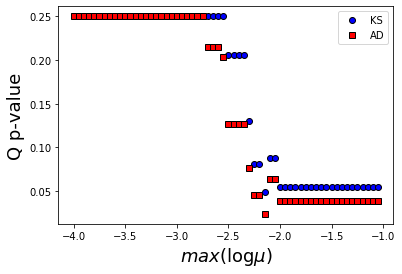

C:\Users\djhoo\Miniconda3\lib\site-packages\ipykernel_launcher.py:46: UserWarning: p-value capped: true value larger than 0.25


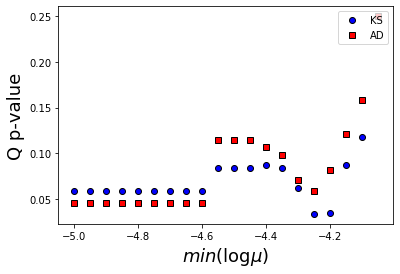

In [11]:
logmu_rv.sort(reverse=True)
Q_original = Q
KS = []
AD = []
upper_logmu = []
for i in range(-80, -20, 1):
    max_logmu = i/20
    Q = Q_original[logmu <= max_logmu]
    detection_methods = detection_methods_original[logmu <= max_logmu]
    
    Q_rv = Q[detection_methods == 'Radial Velocity']
    Q_transit = Q[detection_methods == 'Transit']
    
    if np.array(stats.ks_2samp(Q_rv, Q_transit))[1] < 0.250:
        KS.append(np.array(stats.ks_2samp(Q_rv, Q_transit))[1])
    else:
        KS.append(0.250)
        
    AD.append(stats.anderson_ksamp([Q_rv, Q_transit])[2])
    upper_logmu.append(max_logmu)
    
plt.plot(upper_logmu, KS, 'o', color='blue', mec='black', label='KS')
plt.plot(upper_logmu, AD, 's', color='red', mec='black', label='AD')
plt.xlabel(r'$max(\log{\mu})$', fontsize=18)
plt.ylabel('Q p-value', fontsize=18)
plt.legend(loc='upper right', fontsize=10)
plt.show()

logmu_transit.sort(reverse=False)

KS = []
AD = []
lower_logmu = []
for i in range(-100, -80, 1):
    min_logmu = i/20
    Q = Q_original[logmu >= min_logmu]
    detection_methods = detection_methods_original[logmu >= min_logmu]
    
    Q_rv = Q[detection_methods == 'Radial Velocity']
    Q_transit = Q[detection_methods == 'Transit']
    
    if np.array(stats.ks_2samp(Q_rv, Q_transit))[1] < 0.250:
        KS.append(np.array(stats.ks_2samp(Q_rv, Q_transit))[1])
    else:
        KS.append(0.250)
    AD.append(stats.anderson_ksamp([Q_rv, Q_transit])[2])
    lower_logmu.append(min_logmu)
    
plt.plot(lower_logmu, KS, 'o', color='blue', mec='black', label='KS')
plt.plot(lower_logmu, AD, 's', color='red', mec='black', label='AD')
plt.xlabel(r'$min(\log{\mu})$', fontsize=18)
plt.ylabel('Q p-value', fontsize=18)
plt.legend(loc='upper right', fontsize=10)
plt.show()

C:\Users\djhoo\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: p-value floored: true value smaller than 0.001


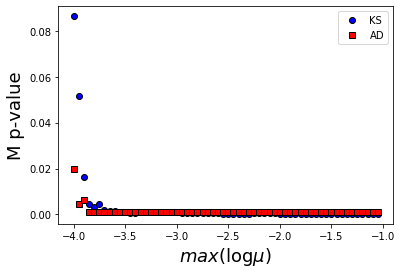

C:\Users\djhoo\Miniconda3\lib\site-packages\ipykernel_launcher.py:46: UserWarning: p-value floored: true value smaller than 0.001


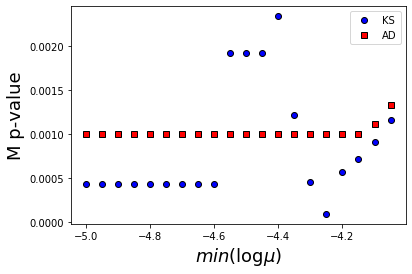

In [12]:
logmu_rv.sort(reverse=True)
M_original = M
KS = []
AD = []
upper_logmu = []
for i in range(-80, -20, 1):
    max_logmu = i/20
    M = M_original[logmu <= max_logmu]
    detection_methods = detection_methods_original[logmu <= max_logmu]
    
    M_rv = M[detection_methods == 'Radial Velocity']
    M_transit = M[detection_methods == 'Transit']
    
    if np.array(stats.ks_2samp(M_rv, M_transit))[1] < 0.250:
        KS.append(np.array(stats.ks_2samp(M_rv, M_transit))[1])
    else:
        KS.append(0.250)
        
    AD.append(stats.anderson_ksamp([M_rv, M_transit])[2])
    upper_logmu.append(max_logmu)
    
plt.plot(upper_logmu, KS, 'o', color='blue', mec='black', label='KS')
plt.plot(upper_logmu, AD, 's', color='red', mec='black', label='AD')
plt.xlabel(r'$max(\log{\mu})$', fontsize=18)
plt.ylabel('M p-value', fontsize=18)
plt.legend(loc='upper right', fontsize=10)
plt.show()

logmu_transit.sort(reverse=False)

KS = []
AD = []
lower_logmu = []
for i in range(-100, -80, 1):
    min_logmu = i/20
    M = M_original[logmu >= min_logmu]
    detection_methods = detection_methods_original[logmu >= min_logmu]
    
    M_rv = M[detection_methods == 'Radial Velocity']
    M_transit = M[detection_methods == 'Transit']
    
    if np.array(stats.ks_2samp(M_rv, M_transit))[1] < 0.250:
        KS.append(np.array(stats.ks_2samp(M_rv, M_transit))[1])
    else:
        KS.append(0.250)
    AD.append(stats.anderson_ksamp([M_rv, M_transit])[2])
    lower_logmu.append(min_logmu)
    
plt.plot(lower_logmu, KS, 'o', color='blue', mec='black', label='KS')
plt.plot(lower_logmu, AD, 's', color='red', mec='black', label='AD')
plt.xlabel(r'$min(\log{\mu})$', fontsize=18)
plt.ylabel('M p-value', fontsize=18)
plt.legend(loc='upper right', fontsize=10)
plt.show()

C:\Users\djhoo\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: p-value capped: true value larger than 0.25


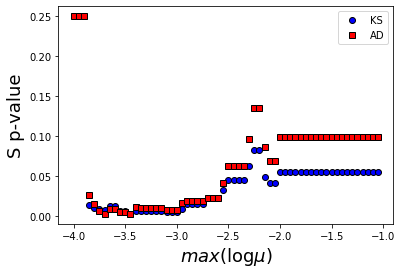

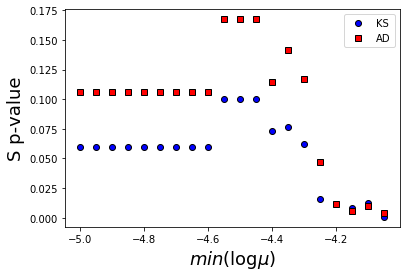

In [13]:
logmu_rv.sort(reverse=True)
S_original = S
KS = []
AD = []
upper_logmu = []
for i in range(-80, -20, 1):
    max_logmu = i/20
    S = S_original[logmu <= max_logmu]
    detection_methods = detection_methods_original[logmu <= max_logmu]
    
    S_rv = S[detection_methods == 'Radial Velocity']
    S_transit = S[detection_methods == 'Transit']
    
    if np.array(stats.ks_2samp(S_rv, S_transit))[1] < 0.250:
        KS.append(np.array(stats.ks_2samp(S_rv, S_transit))[1])
    else:
        KS.append(0.250)
        
    AD.append(stats.anderson_ksamp([S_rv, S_transit])[2])
    upper_logmu.append(max_logmu)
    
plt.plot(upper_logmu, KS, 'o', color='blue', mec='black', label='KS')
plt.plot(upper_logmu, AD, 's', color='red', mec='black', label='AD')
plt.xlabel(r'$max(\log{\mu})$', fontsize=18)
plt.ylabel('S p-value', fontsize=18)
plt.legend(loc='upper right', fontsize=10)
plt.show()

logmu_transit.sort(reverse=False)

KS = []
AD = []
lower_logmu = []
for i in range(-100, -80, 1):
    min_logmu = i/20
    S = S_original[logmu >= min_logmu]
    detection_methods = detection_methods_original[logmu >= min_logmu]
    
    S_rv = S[detection_methods == 'Radial Velocity']
    S_transit = S[detection_methods == 'Transit']
    
    if np.array(stats.ks_2samp(S_rv, S_transit))[1] < 0.250:
        KS.append(np.array(stats.ks_2samp(S_rv, S_transit))[1])
    else:
        KS.append(0.250)
    AD.append(stats.anderson_ksamp([S_rv, S_transit])[2])
    lower_logmu.append(min_logmu)
    
plt.plot(lower_logmu, KS, 'o', color='blue', mec='black', label='KS')
plt.plot(lower_logmu, AD, 's', color='red', mec='black', label='AD')
plt.xlabel(r'$min(\log{\mu})$', fontsize=18)
plt.ylabel('S p-value', fontsize=18)
plt.legend(loc='upper right', fontsize=10)
plt.show()

C:\Users\djhoo\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: p-value capped: true value larger than 0.25


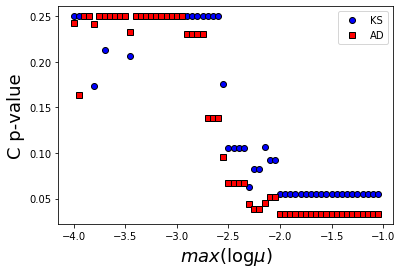

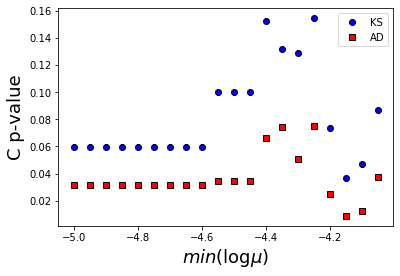

In [14]:
logmu_rv.sort(reverse=True)
C_original = C
KS = []
AD = []
upper_logmu = []
for i in range(-80, -20, 1):
    max_logmu = i/20
    C = C_original[logmu <= max_logmu]
    detection_methods = detection_methods_original[logmu <= max_logmu]
    
    C_rv = C[detection_methods == 'Radial Velocity']
    C_transit = C[detection_methods == 'Transit']
    
    if np.array(stats.ks_2samp(C_rv, C_transit))[1] < 0.250:
        KS.append(np.array(stats.ks_2samp(C_rv, C_transit))[1])
    else:
        KS.append(0.250)
        
    AD.append(stats.anderson_ksamp([C_rv, C_transit])[2])
    upper_logmu.append(max_logmu)
    
plt.plot(upper_logmu, KS, 'o', color='blue', mec='black', label='KS')
plt.plot(upper_logmu, AD, 's', color='red', mec='black', label='AD')
plt.xlabel(r'$max(\log{\mu})$', fontsize=18)
plt.ylabel('C p-value', fontsize=18)
plt.legend(loc='upper right', fontsize=10)
plt.show()

logmu_transit.sort(reverse=False)

KS = []
AD = []
lower_logmu = []
for i in range(-100, -80, 1):
    min_logmu = i/20
    C = C_original[logmu >= min_logmu]
    detection_methods = detection_methods_original[logmu >= min_logmu]
    
    C_rv = C[detection_methods == 'Radial Velocity']
    C_transit = C[detection_methods == 'Transit']
    
    if np.array(stats.ks_2samp(C_rv, C_transit))[1] < 0.250:
        KS.append(np.array(stats.ks_2samp(C_rv, C_transit))[1])
    else:
        KS.append(0.250)
    AD.append(stats.anderson_ksamp([C_rv, C_transit])[2])
    lower_logmu.append(min_logmu)
    
plt.plot(lower_logmu, KS, 'o', color='blue', mec='black', label='KS')
plt.plot(lower_logmu, AD, 's', color='red', mec='black', label='AD')
plt.xlabel(r'$min(\log{\mu})$', fontsize=18)
plt.ylabel('C p-value', fontsize=18)
plt.legend(loc='upper right', fontsize=10)
plt.show()

In [15]:
def legitimate_periods(periods, max_period):
    pass

In [16]:
KS = []
AD = []
upper_period = []
for i in range(1300, 1500, 5):
    legitimate_entries = legitimate_periods(periods, i)
    
    Q = Q_original[legitimate_entries == True]
    detection_methods = detection_methods_original[legitimate_entries == True]
    
    Q_rv = Q[detection_methods == 'Radial Velocity']
    Q_transit = Q[detection_methods == 'Transit']
    
    if np.array(stats.ks_2samp(Q_rv, Q_transit))[1] < 0.250:
        KS.append(np.array(stats.ks_2samp(Q_rv, Q_transit))[1])
    else:
        KS.append(0.250)
        
    AD.append(stats.anderson_ksamp([Q_rv, Q_transit])[2])
    upper_period.append(i)
    
plt.plot(upper_period, KS, 'o', color='blue', mec='black', label='KS')
plt.plot(upper_period, AD, 's', color='red', mec='black', label='AD')
plt.xlabel(r'$max(P)$', fontsize=18)
plt.ylabel('Q p-value', fontsize=18)
plt.legend(loc='upper right', fontsize=10)
plt.show()

ValueError: zero-size array to reduction operation maximum which has no identity

In [ ]:
KS = []
AD = []
upper_period = []
for i in range(1300, 1500, 5):
    legitimate_entries = legitimate_periods(periods, i)
    
    M = M_original[legitimate_entries == True]
    detection_methods = detection_methods_original[legitimate_entries == True]
    
    M_rv = M[detection_methods == 'Radial Velocity']
    M_transit = M[detection_methods == 'Transit']
    
    if np.array(stats.ks_2samp(M_rv, M_transit))[1] < 0.250:
        KS.append(np.array(stats.ks_2samp(M_rv, M_transit))[1])
    else:
        KS.append(0.250)
        
    AD.append(stats.anderson_ksamp([M_rv, M_transit])[2])
    upper_period.append(i)
    
plt.plot(upper_period, KS, 'o', color='blue', mec='black', label='KS')
plt.plot(upper_period, AD, 's', color='red', mec='black', label='AD')
plt.xlabel(r'$max(P)$', fontsize=18)
plt.ylabel('M p-value', fontsize=18)
plt.legend(loc='upper right', fontsize=10)
plt.show()

In [ ]:
KS = []
AD = []
upper_period = []
for i in range(1300, 1500, 5):
    legitimate_entries = legitimate_periods(periods, i)
    
    S = S_original[legitimate_entries == True]
    detection_methods = detection_methods_original[legitimate_entries == True]
    
    S_rv = S[detection_methods == 'Radial Velocity']
    S_transit = S[detection_methods == 'Transit']
    
    if np.array(stats.ks_2samp(S_rv, S_transit))[1] < 0.250:
        KS.append(np.array(stats.ks_2samp(S_rv, S_transit))[1])
    else:
        KS.append(0.250)
        
    AD.append(stats.anderson_ksamp([S_rv, S_transit])[2])
    upper_period.append(i)
    
plt.plot(upper_period, KS, 'o', color='blue', mec='black', label='KS')
plt.plot(upper_period, AD, 's', color='red', mec='black', label='AD')
plt.xlabel(r'$max(P)$', fontsize=18)
plt.ylabel('S p-value', fontsize=18)
plt.legend(loc='upper right', fontsize=10)
plt.show()

In [ ]:
KS = []
AD = []
upper_period = []
for i in range(1300, 1500, 5):
    legitimate_entries = legitimate_periods(periods, i)
    
    C = C_original[legitimate_entries == True]
    detection_methods = detection_methods_original[legitimate_entries == True]
    
    C_rv = C[detection_methods == 'Radial Velocity']
    C_transit = C[detection_methods == 'Transit']
    
    if np.array(stats.ks_2samp(C_rv, C_transit))[1] < 0.250:
        KS.append(np.array(stats.ks_2samp(C_rv, C_transit))[1])
    else:
        KS.append(0.250)
        
    AD.append(stats.anderson_ksamp([C_rv, C_transit])[2])
    upper_period.append(i)
    
plt.plot(upper_period, KS, 'o', color='blue', mec='black', label='KS')
plt.plot(upper_period, AD, 's', color='red', mec='black', label='AD')
plt.xlabel(r'$max(P)$', fontsize=18)
plt.ylabel('C p-value', fontsize=18)
plt.legend(loc='upper right', fontsize=10)
plt.show()

In [ ]:
def legitimate_radii(radii, max_radius):
    pass

In [ ]:
KS = []
AD = []
lower_radius = []
for i in range(0, 50, 2):
    legitimate_entries = legitimate_radii(radii, i/100)
    
    Q = Q_original[legitimate_entries == True]
    detection_methods = detection_methods_original[legitimate_entries == True]
    
    Q_rv = Q[detection_methods == 'Radial Velocity']
    Q_transit = Q[detection_methods == 'Transit']
    
    if np.array(stats.ks_2samp(Q_rv, Q_transit))[1] < 0.250:
        KS.append(np.array(stats.ks_2samp(Q_rv, Q_transit))[1])
    else:
        KS.append(0.250)
        
    AD.append(stats.anderson_ksamp([Q_rv, Q_transit])[2])
    lower_radius.append(i/100)
    
plt.plot(lower_radius, KS, 'o', color='blue', mec='black', label='KS')
plt.plot(lower_radius, AD, 's', color='red', mec='black', label='AD')
plt.xlabel(r'$min(R)$', fontsize=18)
plt.ylabel('Q p-value', fontsize=18)
plt.legend(loc='upper right', fontsize=10)
plt.show()

In [ ]:
KS = []
AD = []
lower_radius = []
for i in range(0, 50, 2):
    legitimate_entries = legitimate_radii(radii, i/100)
    
    M = M_original[legitimate_entries == True]
    detection_methods = detection_methods_original[legitimate_entries == True]
    
    M_rv = M[detection_methods == 'Radial Velocity']
    M_transit = M[detection_methods == 'Transit']
    
    if np.array(stats.ks_2samp(M_rv, M_transit))[1] < 0.250:
        KS.append(np.array(stats.ks_2samp(M_rv, M_transit))[1])
    else:
        KS.append(0.250)
        
    AD.append(stats.anderson_ksamp([M_rv, M_transit])[2])
    lower_radius.append(i/100)
    
plt.plot(lower_radius, KS, 'o', color='blue', mec='black', label='KS')
plt.plot(lower_radius, AD, 's', color='red', mec='black', label='AD')
plt.xlabel(r'$min(R)$', fontsize=18)
plt.ylabel('M p-value', fontsize=18)
plt.legend(loc='upper right', fontsize=10)
plt.show()

In [ ]:
KS = []
AD = []
lower_radius = []
for i in range(0, 50, 2):
    legitimate_entries = legitimate_radii(radii, i/100)
    
    S = S_original[legitimate_entries == True]
    detection_methods = detection_methods_original[legitimate_entries == True]
    
    S_rv = S[detection_methods == 'Radial Velocity']
    S_transit = S[detection_methods == 'Transit']
    
    if np.array(stats.ks_2samp(S_rv, S_transit))[1] < 0.250:
        KS.append(np.array(stats.ks_2samp(S_rv, S_transit))[1])
    else:
        KS.append(0.250)
        
    AD.append(stats.anderson_ksamp([S_rv, S_transit])[2])
    lower_radius.append(i/100)
    
plt.plot(lower_radius, KS, 'o', color='blue', mec='black', label='KS')
plt.plot(lower_radius, AD, 's', color='red', mec='black', label='AD')
plt.xlabel(r'$min(R)$', fontsize=18)
plt.ylabel('S p-value', fontsize=18)
plt.legend(loc='upper right', fontsize=10)
plt.show()

In [ ]:
KS = []
AD = []
lower_radius = []
for i in range(0, 50, 2):
    legitimate_entries = legitimate_radii(radii, i/100)
    
    C = C_original[legitimate_entries == True]
    detection_methods = detection_methods_original[legitimate_entries == True]
    
    C_rv = C[detection_methods == 'Radial Velocity']
    C_transit = C[detection_methods == 'Transit']
    
    if np.array(stats.ks_2samp(C_rv, C_transit))[1] < 0.250:
        KS.append(np.array(stats.ks_2samp(C_rv, C_transit))[1])
    else:
        KS.append(0.250)
        
    AD.append(stats.anderson_ksamp([C_rv, C_transit])[2])
    lower_radius.append(i/100)
    
plt.plot(lower_radius, KS, 'o', color='blue', mec='black', label='KS')
plt.plot(lower_radius, AD, 's', color='red', mec='black', label='AD')
plt.xlabel(r'$min(R)$', fontsize=18)
plt.ylabel('C p-value', fontsize=18)
plt.legend(loc='upper right', fontsize=10)
plt.show()